In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AffinityPropagation
from tqdm import tqdm

# Define function

In [2]:
# Custom function to calculate Levenshtein distance
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# Function to print clusters
def print_clusters(affprop, texts):
    cluster_lexicon = []
    texts = np.asarray(texts)
    clusters = np.unique(affprop.labels_)
    print(f'\n~ Number of texts:: {texts.shape[0]}')
    print(f'~ Number of clusters:: {clusters.shape[0]}')
    if clusters.shape[0] < 2:
        return 'Only few clusters - Stopped'
    for cluster_id in clusters:
        exemplar = texts[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(texts[np.nonzero(affprop.labels_ == cluster_id)])
        cluster_str = '";\n  "'.join(cluster)
        cluster_lexicon.append({'cluster_id': cluster_id, 'exemplar': exemplar, 'cluster': cluster_str})
        print(f'\n# Cluster ({cluster_id}) with ({len(cluster)}) elements')
        print(f'Exemplar:: {exemplar}')
        print(f'\nOthers::\n  "{cluster_str}"')
    return cluster_lexicon

# Custom class to integrate tqdm with Affinity Propagation
class AffinityPropagationWithProgress(AffinityPropagation):
    def fit(self, X, y=None):
        with tqdm(total=self.max_iter, desc="Affinity Propagation") as pbar:
            super().fit(X, y)
            pbar.update(self.n_iter_)
            print(f"Converged after {self.n_iter_} iterations.")
        return self

# Load the data

In [3]:
data = pd.read_csv('../data/all_cleaned_keyword_frequency.csv')

# Extract concepts
concepts = data['Concepts'].to_list()

# Calculate Levenshtein

In [4]:
# Calculate Levenshtein distance matrix with progress bar
lev_similarity = np.zeros((len(concepts), len(concepts)), dtype=np.float32)
for i, w1 in tqdm(enumerate(concepts), total=len(concepts), desc="Calculating distances"):
    for j, w2 in enumerate(concepts):
        lev_similarity[i, j] = -levenshtein_distance(w1, w2)


Calculating distances: 100%|██████████| 200/200 [00:01<00:00, 160.20it/s]


In [5]:
# save levenshtein distance matrix
np.savetxt('../data/levenshtein_distance_matrix.csv', lev_similarity, delimiter=',')


# Affinity Propagation Clustering

In [6]:
# Apply Affinity Propagation clustering with a progress bar
affprop = AffinityPropagationWithProgress(affinity="precomputed", damping=0.5, random_state=42)
affprop.fit(lev_similarity)

Affinity Propagation:  29%|██▉       | 58/200 [00:00<00:00, 3012.18it/s]

Converged after 58 iterations.


AffinityPropagationWithProgress(affinity='precomputed', random_state=42)

In [7]:
# Print the clusters
cluster_lexicon = print_clusters(affprop, concepts)

# Save in a JSON file
pd.DataFrame(cluster_lexicon).to_json('../data/cluster_lexicon.json', orient='records', lines=True)


~ Number of texts:: 200
~ Number of clusters:: 27

# Cluster (0) with (5) elements
Exemplar:: climate change

Others::
  "climate change";
  "climate change adaptation";
  "community response";
  "land use change";
  "social change"

# Cluster (1) with (5) elements
Exemplar:: vulnerability

Others::
  "civil society";
  "neoliberalism";
  "social vulnerability";
  "sustainability";
  "vulnerability"

# Cluster (2) with (12) elements
Exemplar:: migration

Others::
  "adaptation";
  "conservation";
  "coping strategy";
  "education";
  "european union";
  "innovation";
  "livelihood";
  "management practice";
  "migration";
  "mitigation";
  "neighborhood";
  "risk perception"

# Cluster (3) with (2) elements
Exemplar:: social network analysis

Others::
  "social network analysis";
  "social networking (online)"

# Cluster (4) with (2) elements
Exemplar:: conceptual framework

Others::
  "conceptual framework";
  "institutional framework"

# Cluster (5) with (7) elements
Exemplar:: floo

# Generate dataset

In [8]:
# Add the cluster labels to the original dataframe
data['Cluster'] = affprop.labels_

# Save the dataframe with cluster labels to a new CSV file
data.to_csv('../data/all_keyword_frequency_with_clusters.csv', index=False)

<Axes: title={'center': 'Number of concepts in each cluster'}, xlabel='Cluster'>

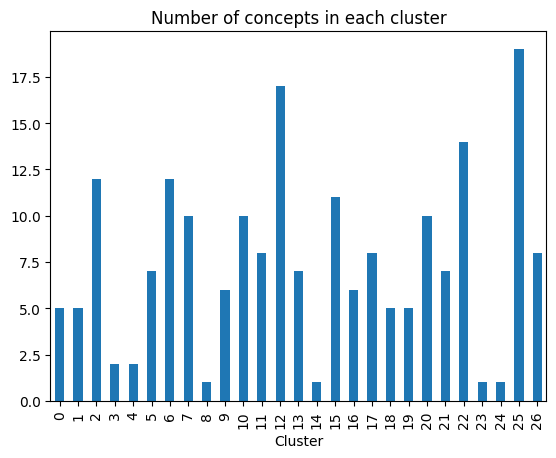

In [9]:
# Count and plot the number of concepts in each cluster
cluster_counts = data['Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar', title='Number of concepts in each cluster')